In [219]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import math
import pickle

import torch
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler
from torch.autograd import Variable
from torch import nn as nn
import copy

from tqdm import tqdm_notebook

from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, classification_report, balanced_accuracy_score

import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
Tensor = FloatTensor

In [7]:
def np_to_tensor(np_data, as_column = False):
    if(as_column):
        np_data = np.array([np_data]).T
        
    return Variable(torch.from_numpy(np_data)).type(torch.FloatTensor)

In [100]:
# train = pd.read_hdf('preprocessed.h5', 'train')
validation = pd.read_hdf('preprocessed.h5', 'validation')
X_resampled, y_resampled = pickle.load(open( "resampled", "rb" ))

In [101]:
X_train = np_to_tensor(X_resampled)
y_train = np_to_tensor(y_resampled, as_column=True)

X_validation = np_to_tensor(validation.drop(columns=['click', 'payprice']).values)
y_validation = np_to_tensor(validation['click'].values, as_column=True)

print(X_train.shape[1] == X_validation.shape[1])

True


In [182]:
seed=622
np.random.seed(seed)
torch.manual_seed(seed)

input_layer = X_train.shape[1]
hidden_layer_1 = 2**9
hidden_layer_2 = 2**9
hidden_layer_3 = 2**5
output_layer = 1 

linear1 = nn.Linear(input_layer, hidden_layer_1)
nn.init.xavier_uniform_(linear1.weight)

linear2 = nn.Linear(hidden_layer_1, hidden_layer_2)
nn.init.xavier_uniform_(linear2.weight)

linear3 = nn.Linear(hidden_layer_2, hidden_layer_3)
nn.init.xavier_uniform_(linear3.weight)

linear4 = nn.Linear(hidden_layer_3, output_layer)
nn.init.xavier_uniform_(linear4.weight)


drop_prob = 0.90
dropout = nn.Dropout(p=(1 - drop_prob))


# todo replace linear hidden layers to convolution layers 
net = torch.nn.Sequential(linear1,
                          nn.BatchNorm1d(hidden_layer_1),
                          nn.ReLU(),
                          linear2,
                          dropout,
                          nn.ReLU(),
                          linear3,
                          dropout,
                          nn.ReLU(),
                          linear4,
                          nn.Sigmoid())
#                           nn.CrossEntropyLoss())

print(net)


Sequential(
  (0): Linear(in_features=932, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Dropout(p=0.09999999999999998)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=32, bias=True)
  (7): Dropout(p=0.09999999999999998)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=1, bias=True)
  (10): Sigmoid()
)


In [241]:
for x in batch:
    len(x)

Epoch 0/1
BCELoss= 0.69215, Log loss=0.69410, ROC AUC=0.52043
found better model

Epoch 1/1
found better model



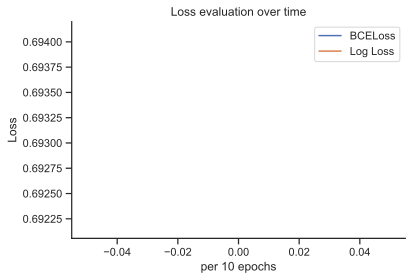

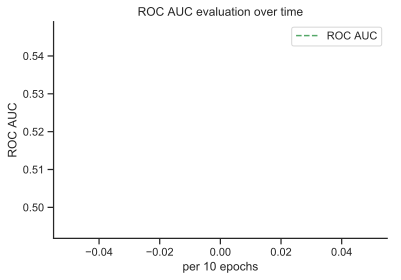

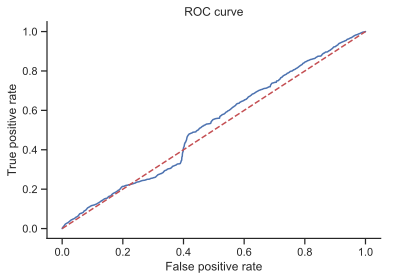

In [253]:
num_epochs = 2
losses = []

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-3)

best_model_wts = copy.deepcopy(net.state_dict())
best_acc = 0.0
min_loss = None

for epoch in tqdm_notebook(range(num_epochs)):
    running_loss = 0.0
    
    batch = BatchSampler(
        RandomSampler(X_train),
        batch_size=round(len(X_train) / 10),
        drop_last=False)
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # iterate over batches
    for minibatch in batch:
        
        X = X_train[minibatch]
        y = y_train[minibatch]
        
        # Set NN to training
        net.train()

        # Forward Propagation
        outputs = net(X)

        # Get classifications
        _, preds = torch.max(outputs, 1)
        
        if (max(preds.numpy()) > 0):
            print('some clicks predicted')
            # TODO: calcualte balanced accuracy and use to save model
            # running_corrects += torch.sum(preds == labels.data
            # balanced_accuracy_score(y_true, y_pred)

        # Compute loss
        loss = criterion(outputs, y)

        # Reset gradients
        optimizer.zero_grad()

        # Backwards propagation error
        loss.backward()

        # Optimise gradients
        optimizer.step()

        running_loss += loss.item() * len(minibatch)

    if epoch % 2 == 0:
        # TODO: replace performance evaluation to validation set

        net.eval()
        prediction = (net(X_train).data).float()
        y_hat = prediction.numpy().squeeze()
        y_true = y_train.data.numpy()

        logloss = log_loss(y_true, y_hat)
        rocauc = roc_auc_score(y_true, y_hat)
        bceloss = loss.item()

        losses.append([bceloss, logloss, rocauc])

        print('BCELoss= {:.5f}, Log loss={:.5f}, ROC AUC={:.5f}'.format(
            bceloss, logloss, rocauc))
        
        
    epoch_loss = running_loss/len(X_train)

    # set min loss on first epoch
    if not (min_loss):
        min_loss = epoch_loss

    # copy best model
    if (loss.item() < epoch_loss):
        print('found better model')
        best_model_wts = copy.deepcopy(net.state_dict())

    # Stop criterion
    if loss.item() < 1e-3:
        break

    print('')

# show some plots
plt.plot(np.array(losses)[:, 0], label='BCELoss')
plt.plot(np.array(losses)[:, 1], label='Log Loss')
plt.title('Loss evaluation over time')
plt.xlabel('per 10 epochs')
plt.ylabel('Loss')
plt.legend()
sns.despine()
plt.show()

plt.plot(np.array(losses)[:, 2], 'g--', label='ROC AUC')
plt.title('ROC AUC evaluation over time')
plt.xlabel('per 10 epochs')
plt.ylabel('ROC AUC')
plt.legend()
sns.despine()
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_hat)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
sns.despine()
plt.show()

## Validation

In [171]:
outputs = net(X_validation)
y_validation_prob_hat = (outputs.data).float().numpy().squeeze()
y_validation_true = y_validation.data.numpy() 

print(y_validation_prob_hat.shape == y_validation_true.squeeze().shape)

logloss = log_loss(target_y, pred_y)
rocauc = roc_auc_score(target_y,pred_y)

print('Log loss={:.5f}, ROC AUC={:.5f} \n'.format(logloss, rocauc))

_, y_validation_class_hat = torch.max(outputs, 1)
y_validation_class_hat = y_validation_class_hat.numpy()
y_validation_true = y_validation_true.squeeze()
max(y_validation_hat)


True
Log loss=0.68444, ROC AUC=0.63096 



0

In [174]:
print(classification_report(y_validation_true, y_validation_hat, target_names=['no click', 'click']))

/Users/davidvanrooij/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidvanrooij/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    no click       1.00      1.00      1.00    303723
       click       0.00      0.00      0.00       202

   micro avg       1.00      1.00      1.00    303925
   macro avg       0.50      0.50      0.50    303925
weighted avg       1.00      1.00      1.00    303925



/Users/davidvanrooij/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
